<a href="https://colab.research.google.com/github/sean-otoole/HODD/blob/main/parkinsons_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install scanpy anndata umap-learn python-igraph louvain h5py leidenalg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 29.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 82.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 51.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 76.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.9/232.9 kB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 115.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 120.1 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Succ

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.chdir("/content/drive/MyDrive/HODD/Kamath_et_al_2022")

In [4]:
import scanpy as sc
import pandas as pd
from scipy.io import mmread
import scipy.sparse

# File paths
matrix_path = "GSE178265_Homo_matrix.mtx.gz"
barcodes_path = "GSE178265_Homo_bcd.tsv.gz"
features_path = "Homo_features.tsv"

# Load sparse count matrix
X = mmread(matrix_path).tocsc()  # Convert to Compressed Sparse Column format for efficiency

# Load barcodes (cell IDs)
barcodes = pd.read_csv(barcodes_path, header=None, sep="\t")[0].values  # Read as a NumPy array

# Load gene names/features
genes = pd.read_csv(features_path, header=None, sep="\t")[0].values  # Read as a NumPy array

# Create AnnData object
adata = sc.AnnData(X.T)
adata.obs_names = barcodes  # Assign cell barcodes
adata.var_names = genes  # Assign gene names

# Verify
print(adata)

AnnData object with n_obs × n_vars = 434340 × 41625


In [5]:
# ensures one doesn't need to recreate this file multiple times

adata.write('/content/drive/MyDrive/HODD/kamath_adata_file.h5ad')


In [4]:
# pick up here

!pip install scanpy anndata umap-learn python-igraph louvain h5py leidenalg

import scanpy as sc
import pandas as pd
from scipy.io import mmread
import scipy.sparse

import os
os.chdir("/content/drive/MyDrive/HODD/Kamath_et_al_2022")

adata = sc.read('/content/drive/MyDrive/HODD/kamath_adata_file.h5ad')

In [5]:
# calculate standard quality control metrics

# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")

In [6]:
mt_genes = adata.var_names[adata.var["mt"] == True]
print(mt_genes)

Index(['MT-ND1', 'MT-ND2', 'MT-CO1', 'MT-CO2', 'MT-ATP8', 'MT-ATP6', 'MT-CO3',
       'MT-ND3', 'MT-ND4L', 'MT-ND4', 'MT-ND5', 'MT-ND6', 'MT-CYB', 'MT-RNR1',
       'MT-RNR2', 'MT-TC', 'MT-TD', 'MT-TF', 'MT-TG', 'MT-TH', 'MT-TI',
       'MT-TL1', 'MT-TL2', 'MT-TM', 'MT-TP', 'MT-TR', 'MT-TS2', 'MT-TT',
       'MT-TV', 'MT-TY'],
      dtype='object')


In [7]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
)

/usr/local/lib/python3.11/dist-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


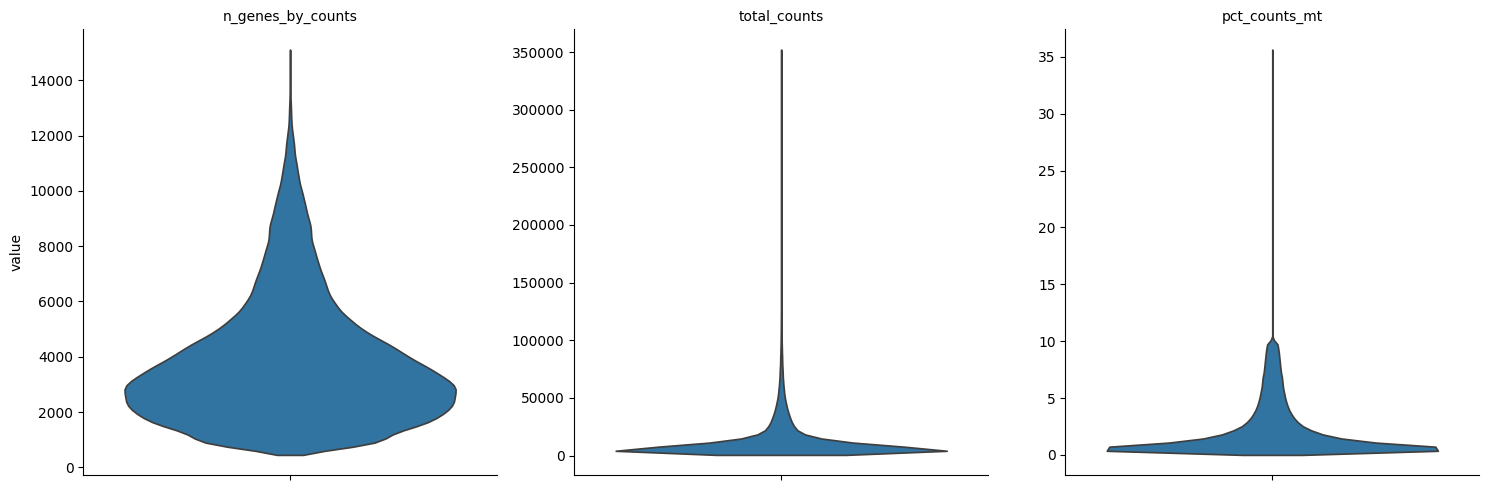

In [8]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    stripplot=False,
    multi_panel=True,
)

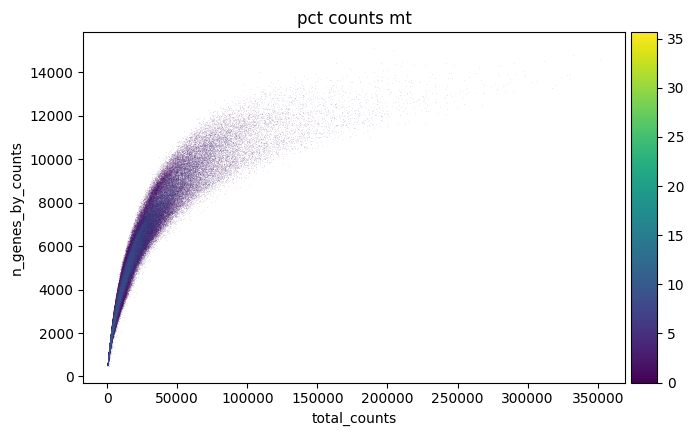

In [9]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [10]:
# Saving count data
adata.layers["counts"] = adata.X.copy()

In [11]:
# Normalizing to median total counts
sc.pp.normalize_total(adata)
# Logarithmize the data
sc.pp.log1p(adata)

In [12]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000)

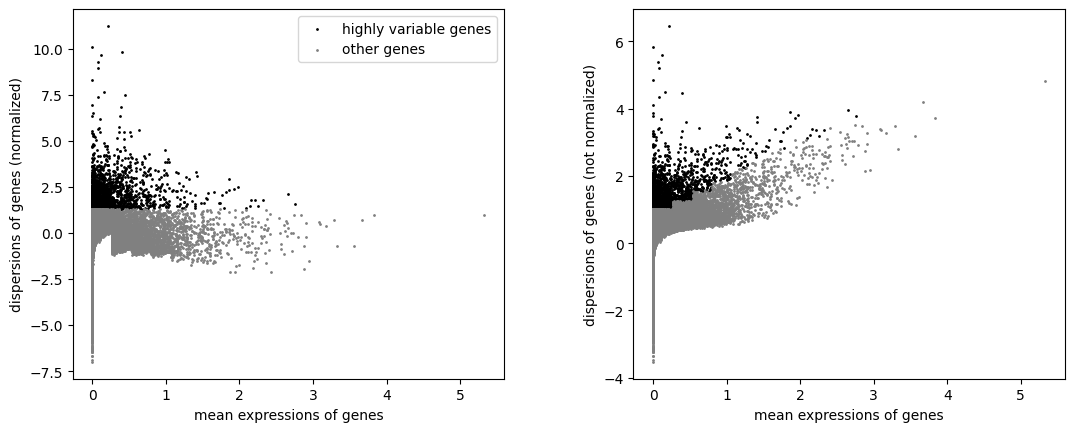

In [13]:
sc.pl.highly_variable_genes(adata)

In [14]:
sc.tl.pca(adata)

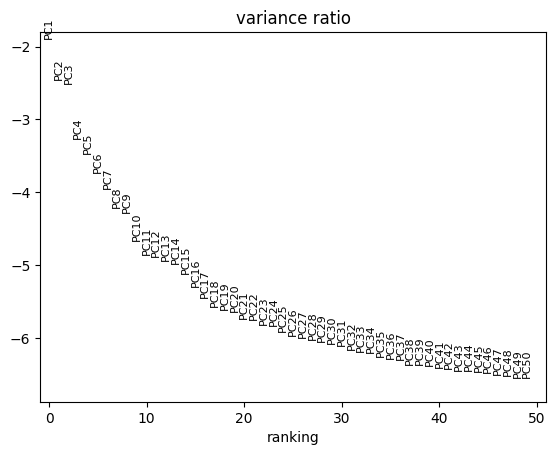

In [15]:
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)


In [16]:
sc.pp.neighbors(adata)


In [ ]:
sc.tl.umap(adata)

In [ ]:
sc.pl.umap(
    adata,
    # Setting a smaller point size to get prevent overlap
    size=2,
)

In [ ]:
# Using the igraph implementation and a fixed number of iterations can be significantly faster, especially for larger datasets
sc.tl.leiden(adata, flavor="igraph", n_iterations=2)

In [ ]:
sc.pl.umap(adata, color=["leiden"])

In [ ]:
adata.write('/content/drive/MyDrive/HODD/kamath_adata_file_procssed.h5ad')